# CS249R Tiny Machine Learning

## Magic Nicla Wand

## Assignment 3


**Harvard University**<br/>
**Fall 2023**<br/>

<hr style="height:2pt">

---

# Set up

Import Dependencies

In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy as np
import PIL
import shutil
import os
import pandas as pd
import json
from google.colab import files
from IPython.display import Image, display
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

Set Global Variables

In [2]:
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
QUANTIZED_FLOAT16_TFL_MODEL_FILENAME = "quantized_float16_model.tfl"
PRUNED_MODEL_FILENAME = "pruned_model.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data.cc"

Set the number of motion classes for your model to classify. The dataset that we provide you has two classes. Specifically, you will be able to classify a circle and a line motion with our wand. If you created your own dataset please make sure to adjust this variable.

In [3]:
NUM_CLASSES = 2

Set seed for reproducibility

In [4]:
np.random.seed(158)

Create checkpoints directory

In [5]:
!mkdir -p checkpoints

Upload your `wanddata.json` file to Collab.

In [6]:
# Use the Google Colab upload button to get the uploaded file.
uploaded = files.upload()

Saving wanddata.json to wanddata.json


Process Uploaded JSON Data

In [7]:
strokes = []
index = 0

for filename in uploaded.keys():
  file_contents = uploaded[filename].decode("utf-8")
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    stroke["index"] = index
    strokes.append(stroke)
    index+=1

# Exploratory Data Analysis

Let's take a look at our data. An IMU provides us with gyroscope and accelerometer readings, represented as Ax, Ay, Az for linear acceleration and Gx, Gy, Gz for rotational velocities. You should have recongized this when you printed out the IMU values using the `nicla_vision_ingestion.ino` script.


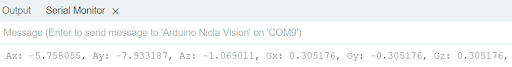


When we process this data, one approach we adopt is to transform these readings into sets of x,y points, effectively plotting the device's motion in a 2D space. As the device moves, the changing accelerometer and gyroscope values are converted into corresponding x,y coordinates. If you are interested in learning more about this data transformation please take a closer look into the `magic_nicla_wand_capture.ino` script we provided you with.

Here is an example of how the motions are stored.

In [8]:
print(f'Motion 0 {strokes[0]["label"]}: ', str(strokes[0]))
print(f'Motion 50 {strokes[50]["label"]}: ', str(strokes[50]))
print(f'Motion 150 {strokes[150]["label"]}: ', str(strokes[150]))

Motion 0 Circle:  {'index': 0, 'strokePoints': [{'x': -0.09375, 'y': -0.0703125}, {'x': -0.09375, 'y': -0.0703125}, {'x': -0.09375, 'y': -0.0703125}, {'x': -0.09375, 'y': -0.0703125}, {'x': -0.09375, 'y': -0.0703125}, {'x': -0.09375, 'y': -0.0703125}, {'x': -0.09375, 'y': -0.0703125}, {'x': -0.09375, 'y': -0.0703125}, {'x': -0.09375, 'y': -0.0703125}, {'x': -0.09375, 'y': -0.0625}, {'x': -0.09375, 'y': -0.0625}, {'x': -0.09375, 'y': -0.0625}, {'x': -0.09375, 'y': -0.0625}, {'x': -0.09375, 'y': -0.0546875}, {'x': -0.09375, 'y': -0.0546875}, {'x': -0.09375, 'y': -0.0546875}, {'x': -0.09375, 'y': -0.0546875}, {'x': -0.09375, 'y': -0.0546875}, {'x': -0.09375, 'y': -0.0546875}, {'x': -0.09375, 'y': -0.046875}, {'x': -0.09375, 'y': -0.046875}, {'x': -0.09375, 'y': -0.046875}, {'x': -0.1015625, 'y': -0.0390625}, {'x': -0.1171875, 'y': -0.0390625}, {'x': -0.125, 'y': -0.03125}, {'x': -0.1484375, 'y': -0.03125}, {'x': -0.1640625, 'y': -0.03125}, {'x': -0.1796875, 'y': -0.0390625}, {'x': -0.1875

Function that helps you plot the x,y data points in each wand motion you collected

In [9]:
def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

Choose a motion to visulize

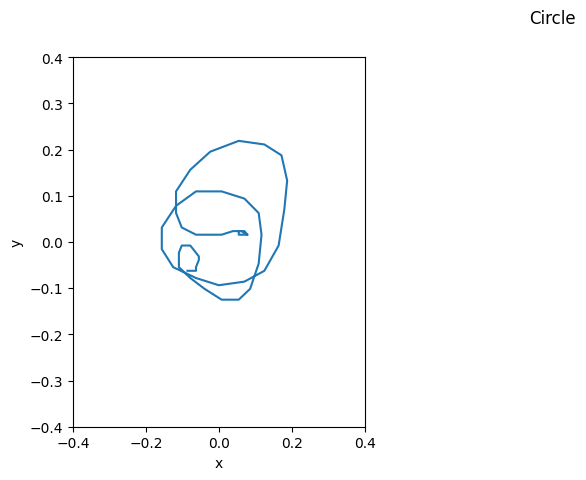

This stroke: 84
All strokes: min 42 max 160 avg 76.29032258064517


In [10]:
shuffled_strokes = list(strokes)
np.random.shuffle(shuffled_strokes)
plot_stroke(shuffled_strokes[0])
print(f"This stroke: {len(shuffled_strokes[0]['strokePoints'])}")
func = lambda x: len(x["strokePoints"])
values = list(map(func, strokes))
print(f"All strokes: min {np.min(values)} max {np.max(values)} avg {np.average(values)}")

The following code rasterizes our stroke data points into a visual image representation. "Rasterizing" refers to the process of converting vector data, like points, lines, and curves, into a grid of pixels, essentially transforming it into an image. This code maps normalized input coordinates onto a defined image canvas and, as the stroke progresses, it uses a gradient color transition from red to green to blue. Why might we want to do this transformation? (Think about the type of machine learning model we can build using this transformed data.)

In [11]:
FIXED_POINT = 4096

def mul_fp(a, b):
  return (a * b) // FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) // b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT // len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

Let's visualize this transformation

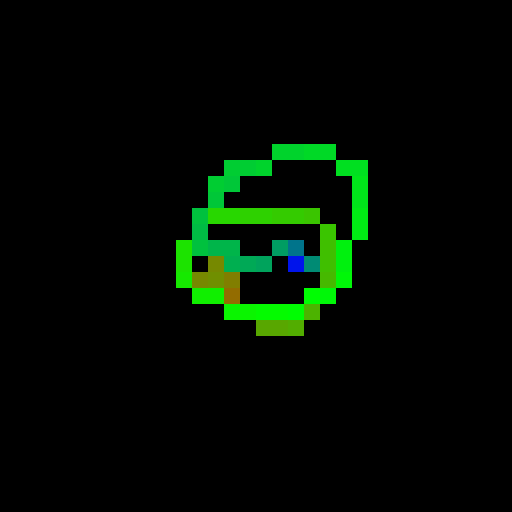

In [12]:
raster = rasterize_stroke(shuffled_strokes[0]["strokePoints"], 0.5, 0.5, 32, 32)
img = PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)
display(img)

Augment the images to enhance the dataset and Save the images

In [13]:
X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
    dirpath = Path(dirname)

    # If directory doesn't exist, create it.
    if not dirpath.exists():
        dirpath.mkdir(parents=True)
    # If directory exists, clear its contents.
    else:
        for child in dirpath.iterdir():
            if child.is_file():
                child.unlink()
            else:
                shutil.rmtree(child)

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
    ensure_empty_dir(root_folder)
    labels = set()
    for stroke in strokes:
        labels.add(stroke["label"].lower())

    for label in labels:
        label_path = Path(root_folder, label)
        if not label_path.exists():
            label_path.mkdir(parents=True)

    label_counts = {}
    for stroke in strokes:
        points = stroke["strokePoints"]
        label = stroke["label"].lower()
        if label == "":
            continue
        if label not in label_counts:
            label_counts[label] = 0
        label_count = label_counts[label]
        label_counts[label] += 1
        raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
        image = PIL.Image.fromarray(raster)
        image_path = Path(root_folder, label, str(label_count) + ".png")
        image.save(image_path)
        for i in range(augment_count):
            augmented_points = augment_points(points, 0.0, 0.1, 0.3)
            raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
            image = PIL.Image.fromarray(raster)
            image_path = Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png")
            image.save(image_path)


Split your data into test, train and validation directories

In [14]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = list(strokes)
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 30
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

Create a validation and training dataset

In [15]:
validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 59 files belonging to 2 classes.
Found 1298 files belonging to 2 classes.


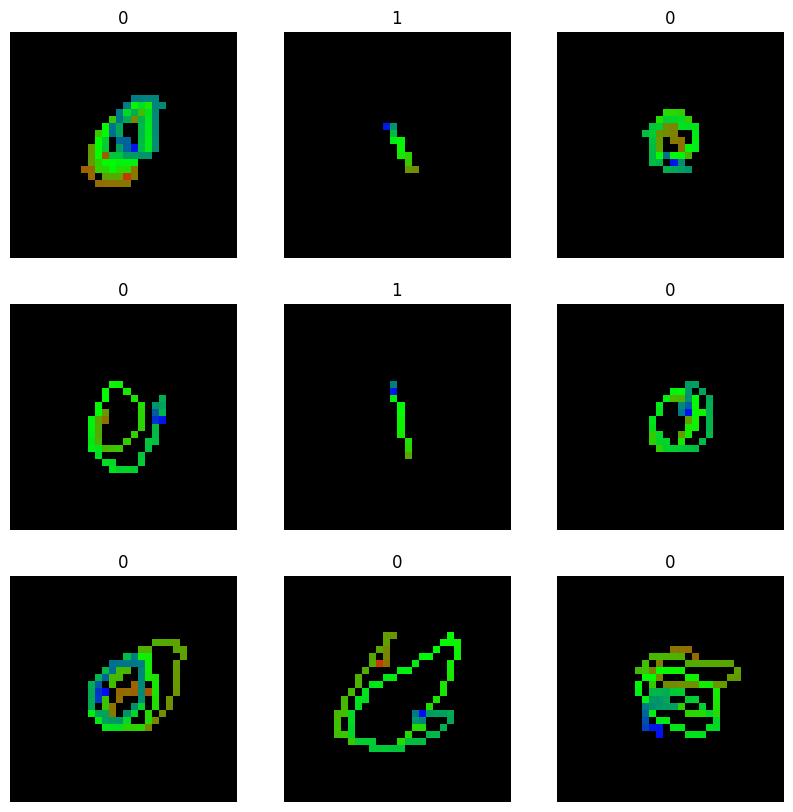

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    ax.set_title(f"{np.argmax(labels[i])}")
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# CNN Model Training

## Section 1: Baseline CNN Model

Here we have a very basic baseline CNN architecture. Starting with a rescaling layer, it normalizes input images to a [0, 1] range. This is followed by a convolutional layer with 8 filters of size 3x3, paired with a stride of 2, which helps in detecting basic features and reduces spatial dimensions. Post-convolution, a ReLU activation function introduces non-linearity. The subsequent global average pooling condenses each feature map to a single value, reducing overfitting risks. Finally, a dense layer classifies the processed data into distinct categories using a softmax activation.

If you are unfamiliar with how CNNs work, you may find [this](https://www.datacamp.com/tutorial/cnn-tensorflow-python) general tutorial helpful.

In [17]:
def make_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1.0 / 255, input_shape=input_shape),

        tf.keras.layers.Conv2D(8, 3, strides=2, padding="same"),
        tf.keras.layers.Activation("relu"),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

Let's visualize our model architecture.

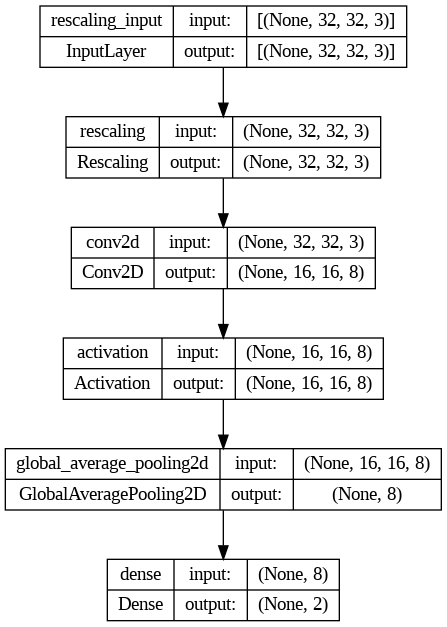

In [18]:
cnn_model = make_cnn_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_CLASSES)
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

Train the model

In [19]:
epochs = 20

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("checkpoints/cnn_save_at_{epoch}.h5"),
]
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
cnn_model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Epoch 1/20
82/82 [==============================] - 1s 5ms/step - loss: 0.6899 - accuracy: 0.4646 - val_loss: 0.6868 - val_accuracy: 0.4407
Epoch 2/20
29/82 [=========>....................] - ETA: 0s - loss: 0.6783 - accuracy: 0.5323

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 0s 4ms/step - loss: 0.6750 - accuracy: 0.4915 - val_loss: 0.6740 - val_accuracy: 0.4407
Epoch 3/20
82/82 [==============================] - 0s 4ms/step - loss: 0.6525 - accuracy: 0.4923 - val_loss: 0.6560 - val_accuracy: 0.4407
Epoch 4/20
82/82 [==============================] - 0s 4ms/step - loss: 0.6240 - accuracy: 0.5223 - val_loss: 0.6349 - val_accuracy: 0.5085
Epoch 5/20
82/82 [==============================] - 0s 6ms/step - loss: 0.5942 - accuracy: 0.5716 - val_loss: 0.6141 - val_accuracy: 0.5424
Epoch 6/20
82/82 [==============================] - 1s 6ms/step - loss: 0.5667 - accuracy: 0.6225 - val_loss: 0.5946 - val_accuracy: 0.6441
Epoch 7/20
82/82 [==============================] - 0s 4ms/step - loss: 0.5427 - accuracy: 0.6641 - val_loss: 0.5768 - val_accuracy: 0.7288
Epoch 8/20
82/82 [==============================] - 0s 4ms/step - loss: 0.5219 - accuracy: 0.7188 - val_loss: 0.5605 - val_accuracy: 0.7288
Epoch 9/20
82/82 [=============

Not too bad for a very simple model.

Let's try to predict an image using this model.

In [20]:
def predict_image(model, directory, label, filename):

    file_path = os.path.join(directory, label, filename)

    # Check if the file exists
    if not os.path.exists(file_path):
        raise ValueError(f"File not found: {file_path}")

    # Load the image with TensorFlow methods
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [IMAGE_WIDTH, IMAGE_HEIGHT])
    img_array = tf.expand_dims(img, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0).flatten()
    predicted_label_index = np.argmax(predictions)
    predicted_score = predictions[predicted_label_index]
    return (predicted_label_index, predicted_score)

directory = "test"
label = "circle" # You may need to change this according to your wand gestures
filename = "0.png"
index, score = predict_image(cnn_model, directory, label, filename)
print(f'Predicted Class index {index}, Predicted Class Probability: {score}')

Predicted Class index 0, Predicted Class Probability: 0.9997609257698059


Let's check the overall accuracy of the model on our test set

In [21]:
def calculate_accuracy(model, directory):
    total_correct_predictions = 0
    total_predictions = 0

    # Get all sub-directories in the main directory
    class_labels = [d for d in sorted(os.listdir(directory)) if os.path.isdir(os.path.join(directory, d))]

    # Iterate over each class directory
    for label in class_labels:
        class_dir = os.path.join(directory, label)

        if not os.path.exists(class_dir):
            raise ValueError(f"Directory not found: {class_dir}")

        # Get all PNG files in the class directory
        file_names = [f for f in sorted(os.listdir(class_dir)) if f.endswith('.png')]

        # Iterate over each image in the class directory
        for filename in file_names:
            predicted_index, _ = predict_image(model, directory, label, filename)

            if class_labels[predicted_index] == label:
                total_correct_predictions += 1
            total_predictions += 1

    # Calculate accuracy
    accuracy = total_correct_predictions / total_predictions
    return accuracy


In [22]:
directory = "test"
accuracy = calculate_accuracy(cnn_model, directory)
print(f'Total Accuracy: {accuracy:.2%}')

Total Accuracy: 89.55%


**Question**: What is the total accuracy for this baseline CNN model on the test dataset?

Let's save the Tensorflow model we just trained.

In [23]:
cnn_model.save(SAVED_MODEL_FILENAME)

Now we can use the Tensorflow model and convert it to a Tensorflow Lite model. We will convert it to both a quantized model and a model that is not quantized.

In [24]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("test/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

2992

Let's compare the model size of these three models.

In [25]:
def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,107431 bytes,
TensorFlow Lite,3212 bytes,(reduced by 104219 bytes)
TensorFlow Lite Quantized,2992 bytes,(reduced by 220 bytes)


**Question**: How large is your Tensorflow, TensorFlow Lite, and Tensorflow Lite Quantized models for this baseline CNN? How many times smaller is the quantized model from the original tensorflow model?

Super cool!


## Section 2: Your Turn! Building a CNN and Quantization

**Question:** Now it's your turn to put on your machine learning hat. In the example above we trained a very basic CNN model. Your task is to build a CNN model that performs better than our baseline model. We will provide you with the architecture of the model you will need to build. Please fill out the code below within the **make_cnn_model** to follow the model architecture in the following image:

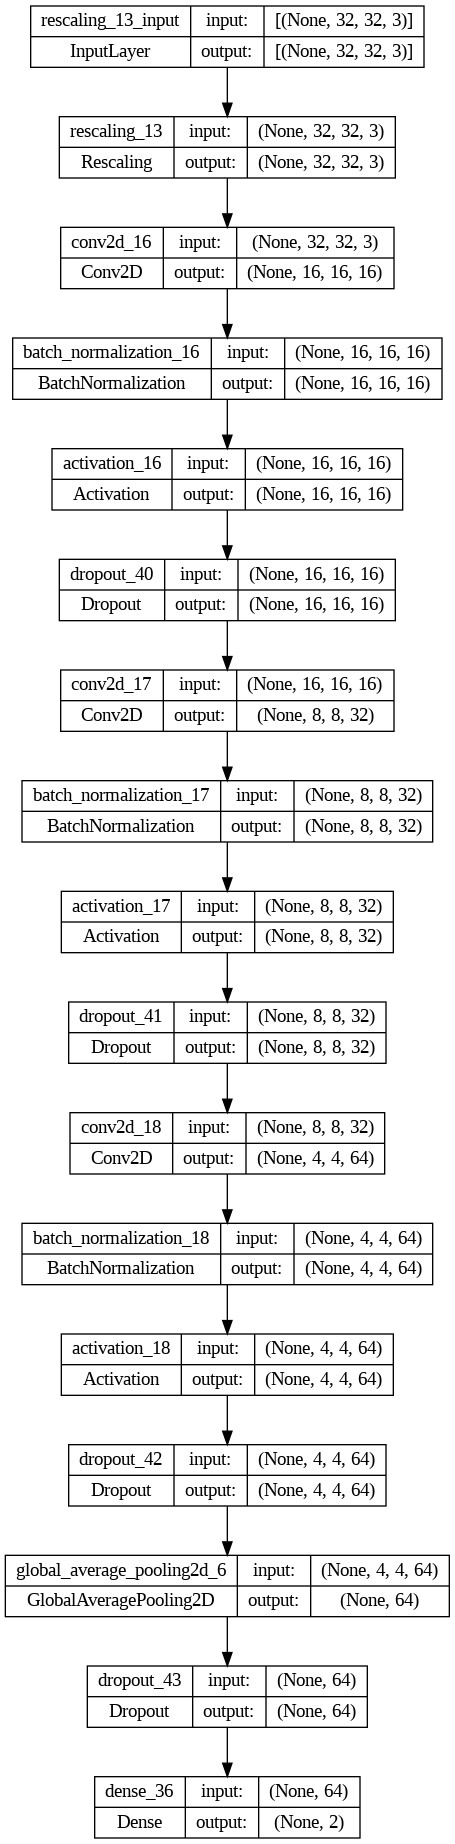

Hint:

* You will need to use the Conv2D, BatchNormalization, Activation, and Dropout operators.
* Use a filter size of 3x3, stride of 2, and you may set your padding to `same` for your convolution layers
* Use ReLU activation function after your convolution layers.
* Set your drop out layer rate to 0.5 in an attempt to reduce overfitting.

In [51]:
def make_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1.0 / 255, input_shape=input_shape),

        # TODO: Add your code here
        # Convolutional Block 1
        tf.keras.layers.Conv2D(16, (3, 3), strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        # Convolutional Block 2
        tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        # Convolutional Block 3
        tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')

    ])
    return model

Visualize your model architecture. This should match the model architecture image provided to you.

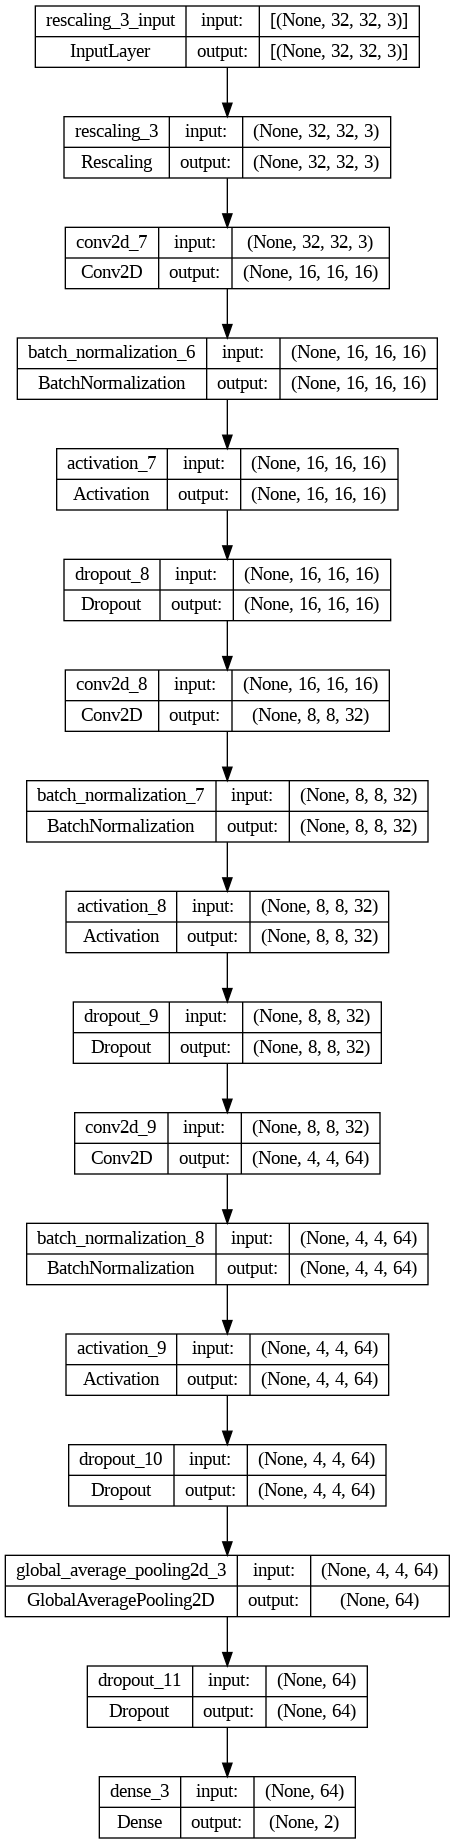

In [52]:
cnn_model = make_cnn_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_CLASSES)
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

Train your model

In [62]:
epochs = 30

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("checkpoints/cnn_save_at_{epoch}.h5"),
]
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
cnn_model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Epoch 1/30
82/82 [==============================] - 2s 11ms/step - loss: 0.0390 - accuracy: 0.9915 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 2/30
82/82 [==============================] - 1s 13ms/step - loss: 0.0411 - accuracy: 0.9846 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 3/30
82/82 [==============================] - 1s 13ms/step - loss: 0.0410 - accuracy: 0.9838 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/30
82/82 [==============================] - 1s 10ms/step - loss: 0.0323 - accuracy: 0.9923 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 5/30
82/82 [==============================] - 1s 10ms/step - loss: 0.0317 - accuracy: 0.9884 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 6/30
82/82 [==============================] - 1s 9ms/step - loss: 0.0406 - accuracy: 0.9869 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 7/30
82/82 [==============================] - 1s 9ms/step - loss: 0.0481 - accuracy: 0.9800 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 8/30
82/8

Try to run inference on the model you just trained

In [63]:
directory = "test"
label = "circle" # You may need to change this according to your wand gestures
filename = "0.png"
index, score = predict_image(cnn_model, directory, label, filename)
print(f'Predicted Class index {index}, Predicted Class Probability: {score}')

Predicted Class index 0, Predicted Class Probability: 1.0


Let's evaluate our accuracy on the test data

In [64]:
directory = "test"
accuracy = calculate_accuracy(cnn_model, directory)
print(f'Total Accuracy: {accuracy:.2%}')

Total Accuracy: 95.45%


**Question**: What is the total accuracy for the CNN model that you built on the test dataset?

Save the model you just trained

In [48]:
cnn_model.summary()
cnn_model.save(SAVED_MODEL_FILENAME)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 16, 16, 16)        64        
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 16, 16, 16)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640      
                                                      

We can now convert our Tensorflow model to Tensorflow Lite and apply quantization to reduce our model size.

In [33]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("test/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

31112

**Question**: Given the code snippet provided, which converts a TensorFlow model to TensorFlow Lite (TFLite) format both in its regular and quantized forms, could you explain the quantization method applied? Specifically, which parts of the model undergo quantization? To what values or types are they being quantized. Additionally, how does the representative_dataset function contribute to this process? You may find these references helpful [1](https://www.tensorflow.org/lite/performance/post_training_quantization), [2](https://www.tensorflow.org/lite/performance/post_training_integer_quant), [3](https://www.tensorflow.org/lite/performance/post_training_float16_quant)

**Question:** Now it's your turn to try quantization. Please apply [Float16 Quantization](https://www.tensorflow.org/lite/performance/post_training_float16_quant) to your model weights by filling in the following code.



In [34]:
# Load converter for quantized model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)

# Set the optimization to FLOAT16
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

model_tflite_float16 = converter.convert()

# Save the FLOAT16 quantized model to disk
open(QUANTIZED_FLOAT16_TFL_MODEL_FILENAME, "wb").write(model_tflite_float16)

53124

**Question**: Please discuss the trade-offs between Float16 Quantization and the quantization method you applied in the previous cell.

Test inference on your TFLite models.

In [35]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

TFLite with No Quantization Model Inference

In [36]:
predict_tflite(model_no_quant_tflite, "test/circle/2.png")

(0, 0.99998856)

TFLite with Quantization Model Inference

In [37]:
predict_tflite(model_tflite, "test/circle/2.png")

(0, 0.99609375)

TFLite with Float16 Quantization Model Inference

In [38]:
predict_tflite(model_tflite_float16, "test/circle/2.png")

(0, 0.99998844)

In [39]:
def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)
size_float16_tflite = os.path.getsize(QUANTIZED_FLOAT16_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Float16 Quantized", f"{size_float16_tflite} bytes ", f"(reduced by {size_tf - size_float16_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_tf - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,639685 bytes,
TensorFlow Lite,98792 bytes,(reduced by 540893 bytes)
TensorFlow Lite Float16 Quantized,53124 bytes,(reduced by 586561 bytes)
TensorFlow Lite Quantized,31112 bytes,(reduced by 608573 bytes)


**Question**: How large is your Tensorflow, TensorFlow Lite, and Tensorflow Lite Quantized models for this CNN? How many times smaller is your quantized model from the original tensorflow model?

**Question**: How many times smaller is your Tensorflow Lite Float16 Quantized model from the Tensorflow Lite model? Why is this the case?


## Section 3: Pruning


Although our model is already pretty small, we would like to be able to compress this further.

One way that we can compress a model is by **model pruning**. Pruning involves setting the weights of a connection between two layers to zero, if the magnitude of that weight is below a threshold value (typically very small). Since we know that these values are all zero, we won't have to worry about storing them. Thus, this can help to reduce the size of our model and is therefore especially useful for TinyML.

In [40]:
# Install TensorFlow Model Optimization Toolkit
!pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 6.3 MB/s eta 0:00:00


In [41]:
import tensorflow_model_optimization as tfmot

We will apply pruning to the CNN model architecture you built. However, we need to specify what layers to apply pruning to.

**Question**: Please use the `pruning_layers` function to wrap your **Conv2D** and your **Dense** layers. You may insert and modify the model architecture that your wrote from above. You should arrive at the following model architecture:

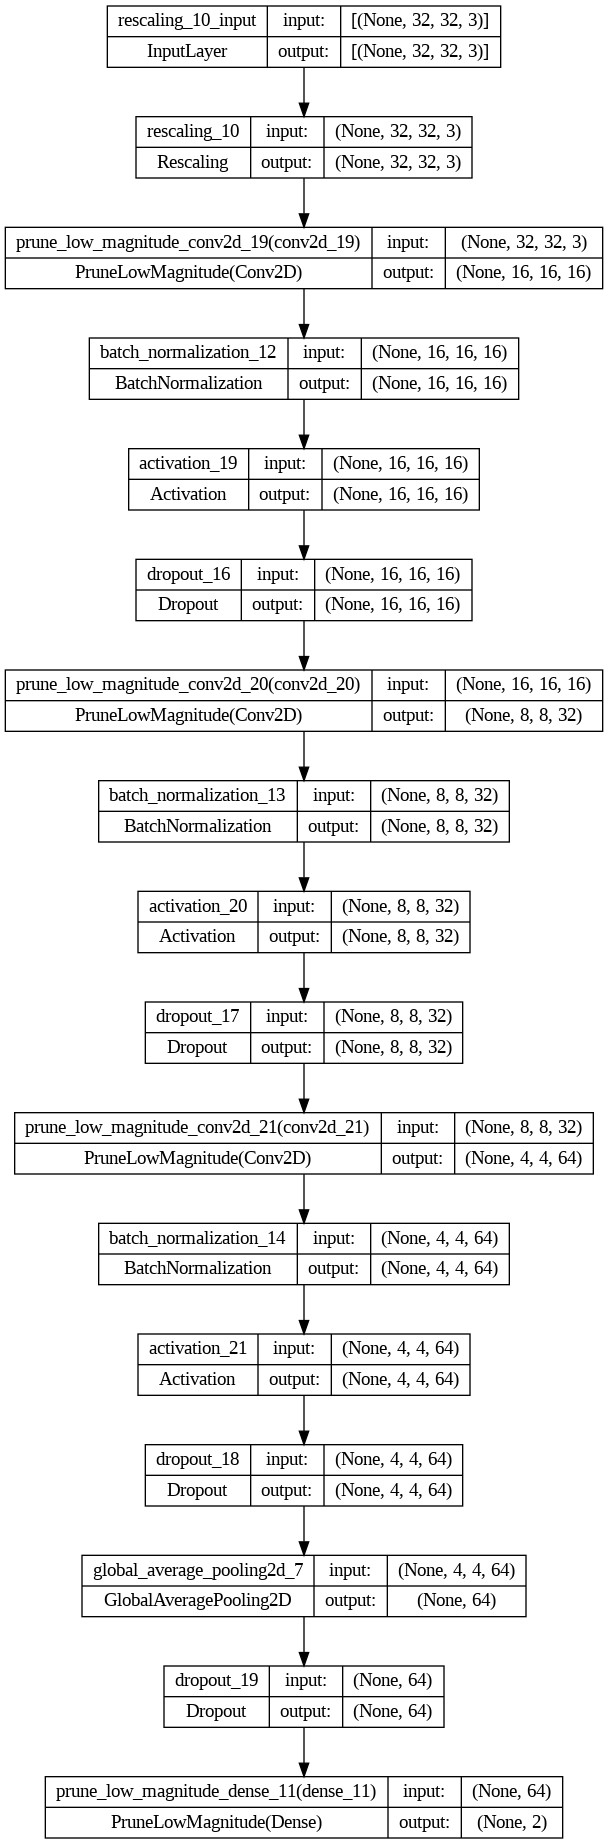

In [57]:
def make_pruned_cnn_model(input_shape, num_classes):
    pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                                                final_sparsity=0.5,
                                                                                begin_step=2000,
                                                                                end_step=4000)}
    pruning_layers = tfmot.sparsity.keras.prune_low_magnitude

    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1.0 / 255, input_shape=input_shape),

        # TODO: please fill the rest of the model architecture here
        # (copy your implementation from above)
        # Apply pruning to each Conv2D and Dense Layer
        # Convolutional Block 1
        pruning_layers(tf.keras.layers.Conv2D(16, (3, 3), strides=2, padding='same'), **pruning_params),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        # Convolutional Block 2
        pruning_layers(tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same'), **pruning_params),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        # Convolutional Block 3
        pruning_layers(tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='same'), **pruning_params),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),

        # Applying pruning to the Dense layer has been done for you.
        pruning_layers(tf.keras.layers.Dense(num_classes, activation='softmax'))

    ])
    return model

Visualize your model architecture to verify it matches the one we requested above.

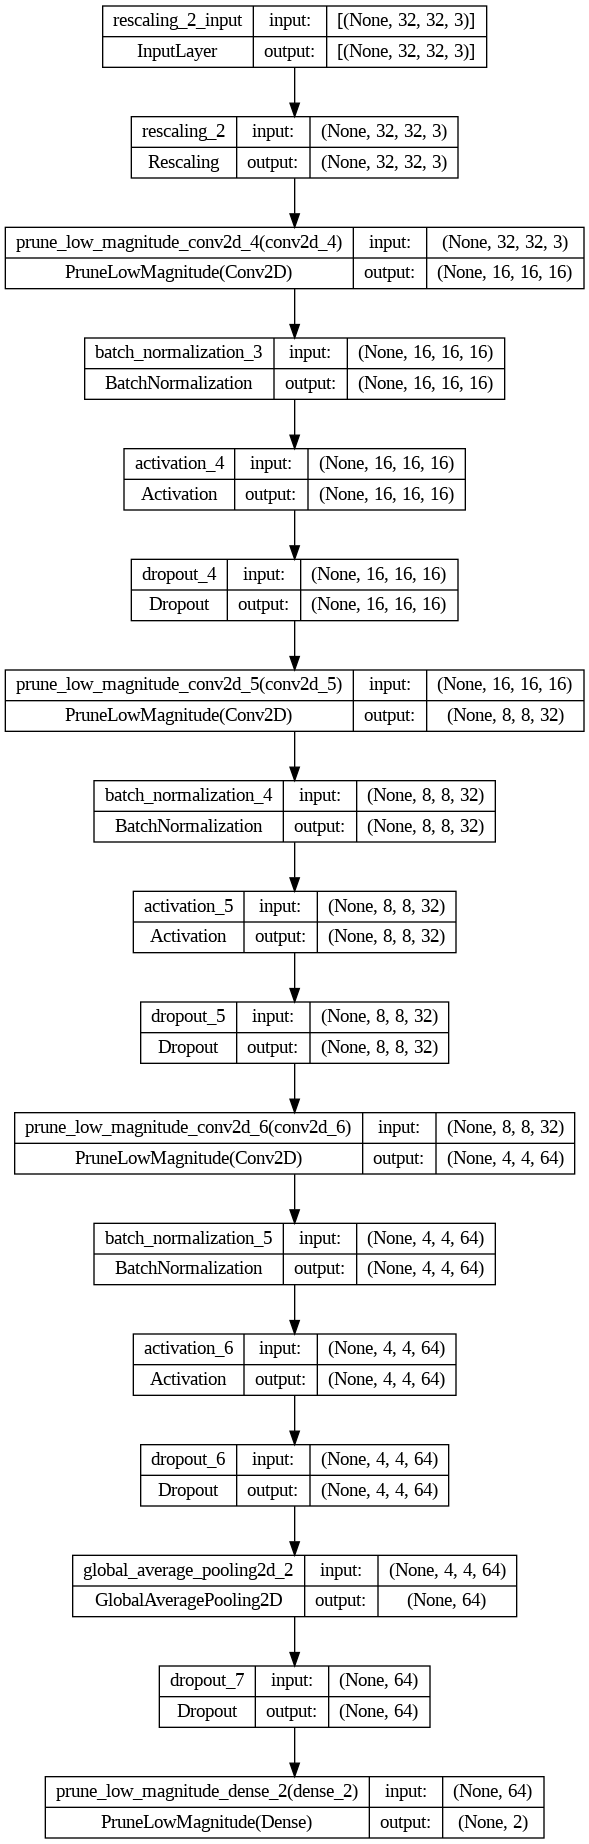

In [43]:
pruned_cnn_model = make_pruned_cnn_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_CLASSES)
tf.keras.utils.plot_model(pruned_cnn_model, show_shapes=True)

In [44]:
# Define pruning parameters
batch_size = 16
num_samples_train = tf.data.experimental.cardinality(train_ds).numpy() * batch_size
epochs = 30

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                             final_sparsity=0.80,
                                                             begin_step=0,
                                                             end_step=np.ceil(num_samples_train / batch_size).astype(np.int32) * epochs)
}

# Compile the pruned model
pruned_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

pruned_cnn_model.summary()

# Update your training process to include pruning callback
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),  # Pruning callback
    tf.keras.callbacks.ModelCheckpoint("checkpoints/cnn_save_at_{epoch}.h5"),
]

pruned_cnn_model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 prune_low_magnitude_conv2d  (None, 16, 16, 16)        882       
 _4 (PruneLowMagnitude)                                          
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 16)        64        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 16, 16, 16)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 16)        0         
                                                                 
 prune_low_magnitude_conv2d  (None, 8, 8, 32)         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
82/82 [==============================] - 1s 10ms/step - loss: 0.3258 - accuracy: 0.9153 - val_loss: 0.7318 - val_accuracy: 0.5593
Epoch 3/30
82/82 [==============================] - 1s 10ms/step - loss: 0.2691 - accuracy: 0.9407 - val_loss: 0.7299 - val_accuracy: 0.5593
Epoch 4/30
82/82 [==============================] - 1s 10ms/step - loss: 0.2349 - accuracy: 0.9345 - val_loss: 0.6062 - val_accuracy: 0.5763
Epoch 5/30
82/82 [==============================] - 1s 12ms/step - loss: 0.1951 - accuracy: 0.9430 - val_loss: 0.3641 - val_accuracy: 0.7627
Epoch 6/30
82/82 [==============================] - 1s 13ms/step - loss: 0.1726 - accuracy: 0.9569 - val_loss: 0.1827 - val_accuracy: 0.9831
Epoch 7/30
82/82 [==============================] - 1s 10ms/step - loss: 0.1642 - accuracy: 0.9576 - val_loss: 0.0865 - val_accuracy: 0.9831
Epoch 8/30
82/82 [==============================] - 1s 10ms/step - loss: 0.1508 - accuracy: 0.9561 - val_loss: 0.0456 - val_accuracy: 1.0000
Epoch 9/30
82

Try to run inference on the model you just trained

In [45]:
directory = "test"
label = "circle"
filename = "0.png"
index, score = predict_image(pruned_cnn_model, directory, label, filename)
print(f'Predicted Class index {index}, Predicted Class Probability: {score}')

Predicted Class index 0, Predicted Class Probability: 0.9999996423721313


Let's evaluate our accuracy on the test data

In [46]:
directory = "test"
accuracy = calculate_accuracy(pruned_cnn_model, directory)
print(f'Total Accuracy: {accuracy:.2%}')

Total Accuracy: 94.09%


**Question**: What is the total accuracy for pruned CNN model that you built on the test dataset?

View the pruned model

In [47]:
# Stripping the pruning layers for saving and converting
pruned_cnn_model = tfmot.sparsity.keras.strip_pruning(pruned_cnn_model)
pruned_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        448       
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 16)        64        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 16, 16, 16)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          4640      
                                                      

**Question**: Please examine the summary table after pruning and describe what you learned about the effect of the pruning process on the model structure. (Hint: Compare it to the previous summary table)

Save the pruned model

In [49]:
pruned_cnn_model.save(PRUNED_MODEL_FILENAME)

In [50]:
def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_pruned = os.path.getsize(PRUNED_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["Pruned TensorFlow", f"{size_pruned} bytes ", f"(reduced by {size_tf - size_pruned} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,640189 bytes,
Pruned TensorFlow,4096 bytes,(reduced by 636093 bytes)


Wow! We reduced the model size by a significant amount.

**Question**: Out of all the models you trained, what model would you choose? Please justify your answer.

# Deployment

## Section 4: Tensorflow Lite Micro

We can now take our quantized model and turn it into a format used by Tensorflow Lite Micro.

In [65]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [46.6 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,419 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [49.8 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadc

In [66]:
# Print the C source file
!tail {TFL_CC_MODEL_FILENAME}

  0x4c, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xd0, 0xff, 0xff, 0xff, 0x19, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x19, 0xe0, 0xff, 0xff, 0xff,
  0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09,
  0xf0, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x28, 0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_data_len = 31112;


**Question**: Download and Open up your `magic_wand_model_data.cc`.  Please explain what this file contains. (Hint: What does the array of hexadecimal values represent?)

# Submission

## Coding Implementations

Section 2

1.   Complete the CNN architecture in the **make_cnn_model** function.
2.    Apply Float16 Quantization to your model weights.

Section 3:
1.   Apply pruning to each Conv2D and Dense Layer within the **make_pruned_cnn_model** function.


## Write up questions:

Section 0:


1.   Insert an image of your serial monitor IMU readings.
2.   Specify if you used the dataset we provided you with or you collected your own. If you did collect your own dataset, please submit the .json file and describe the classes in your dataset.


Section 1

1. What is the total accuracy for this baseline CNN model on the test dataset?

2. How large is your Tensorflow, TensorFlow Lite, and Tensorflow Lite Quantized models for this baseline CNN? How many times smaller is the quantized model from the original tensorflow model?

Section 2

1. What is the total accuracy for the CNN model that you built on the test dataset?

2. Given the code snippet provided, which converts a TensorFlow model to TensorFlow Lite (TFLite) format both in its regular and quantized forms, could you explain the quantization method applied? Specifically, which parts of the model undergo quantization? To what values or types are they being quantized. Additionally, how does the representative_dataset function contribute to this process?

3. Please discuss the trade-offs between Float16 Quantization and the quantization method you applied in the previous cell.

4. How large is your Tensorflow, TensorFlow Lite, and Tensorflow Lite Quantized models for this CNN? How many times smaller is your quantized model from the original tensorflow model?

5. How many times smaller is your Tensorflow Lite Float16 Quantized model from the Tensorflow Lite model? Why is this the case?

Section 3

1. What is the total accuracy for pruned CNN model that you built on the test dataset?

2. Please examine the summary table after pruning and describe what you learned about the effect of the pruning process on the model structure. (Hint: Compare it to the previous summary table)

3. Out of all the models you trained, what model would you choose? Please justify your answer.

Section 4

1.   Download and open up your `magic_wand_model_data.cc`. Please explain what this file contains. (Hint: What does the array of hexadecimal values represent?)

## Files to Submit

1.   Download your final `magic_wand_model_data.cc` and `quantized_model.tfl` you will need to submit these files.
2.   Download your Colab file as a .ipynb file (File > Download > .ipynb). You will need to submit this file.
3. Submit a PDF containing your answers to the questions mentioned above. Structure your write-up according to the specified sections (Sections 1-4). Ensure that all questions are numbered in accordance with the numbering given in these instructions. Any questions not placed under their respective section and question numbers will not be graded. Do not include your coding implementations in the write-up; your code will be reviewed through the .ipynb file that you submit. Limit your write-up to a maximum of three pages. Content beyond the third page will not be graded.



